In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from flask import Flask, jsonify, request

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

# import warnings
# warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [28]:
train, test = train_test_split(df, test_size= 0.1, random_state= 42)

In [29]:
train.to_csv("./data/train_wines.csv")

In [30]:
test.to_csv("./data/test_wines.csv")

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5847 entries, 3764 to 860
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5847 non-null   float64
 1   volatile acidity      5847 non-null   float64
 2   citric acid           5847 non-null   float64
 3   residual sugar        5847 non-null   float64
 4   chlorides             5847 non-null   float64
 5   free sulfur dioxide   5847 non-null   float64
 6   total sulfur dioxide  5847 non-null   float64
 7   density               5847 non-null   float64
 8   pH                    5847 non-null   float64
 9   sulphates             5847 non-null   float64
 10  alcohol               5847 non-null   float64
 11  quality               5847 non-null   int64  
 12  class                 5847 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 639.5+ KB


In [32]:
train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000
mean,7.211279,0.339714,0.319453,5.456225,0.055999,30.598854,115.787070,0.994711,3.218904,0.531115,10.483753,5.816316
std,1.294622,0.163016,0.146191,4.765188,0.034111,17.886676,56.639036,0.003005,0.160252,0.148691,1.192363,0.873717
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992350,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.410000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.330000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [33]:
target = "class"
train[target] = (train[target] == "white").astype(int)
X_train = train.drop(columns = target)
y_train = train[target].copy()

In [34]:
y_train.value_counts(True)

class
1    0.752694
0    0.247306
Name: proportion, dtype: float64

In [35]:
rf_selection = RandomForestClassifier(max_depth= 10, class_weight= "balanced")
rfe = RFE(rf_selection, n_features_to_select=4)
X_train_s = pd.DataFrame(rfe.fit_transform(X_train, y_train), columns= rfe.get_feature_names_out())

In [36]:
X_train_s

,volatile acidity,chlorides,total sulfur dioxide,sulphates
0,0.12,0.034,99.0,0.57
1,0.55,0.076,40.0,0.59
2,0.17,0.093,136.0,0.49
3,0.26,0.045,166.0,0.46
4,0.21,0.038,183.0,0.48
...,...,...,...,...
5842,0.24,0.047,211.0,0.57
5843,0.22,0.058,125.0,0.45
5844,0.20,0.052,145.0,0.56
5845,0.41,0.032,74.0,0.35


In [37]:
X_test = test[X_train_s.columns.to_list()].copy()
y_test = (test[target] == "white").astype(int)

In [38]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_s, y_train)

LogisticRegression(max_iter=10000)

In [39]:
y_pred = log_reg.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       153
           1       0.98      0.98      0.98       497

    accuracy                           0.98       650
   macro avg       0.97      0.97      0.97       650
weighted avg       0.98      0.98      0.98       650



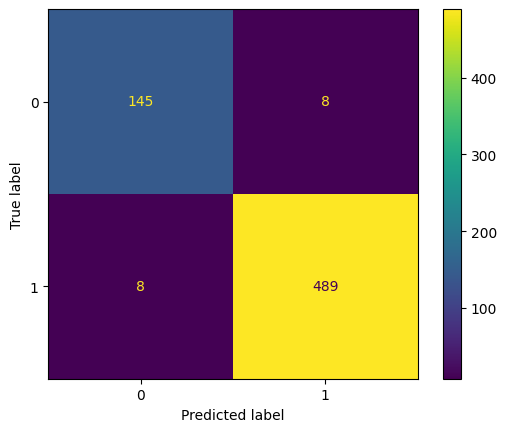

In [41]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, y_pred)

In [42]:
joblib.dump(log_reg, 'my_model.joblib')

['my_model.joblib']

In [43]:

model = LGBMClassifier(max_depth= 10, class_weight= "balanced", random_state= 42)

pipeline = Pipeline(
    [("Imputer", SimpleImputer()),
     ("Model", model)]
)

pipeline.fit(X_train_s.values, y_train.values)

[LightGBM] [Info] Number of positive: 4401, number of negative: 1446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 5847, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('Imputer', SimpleImputer()),
                ('Model',
                 LGBMClassifier(class_weight='balanced', max_depth=10,
                                random_state=42))])

In [44]:
y_pred = pipeline.predict(X_test.values)

c:\Users\dario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       153
           1       1.00      0.99      1.00       497

    accuracy                           0.99       650
   macro avg       0.99      0.99      0.99       650
weighted avg       0.99      0.99      0.99       650



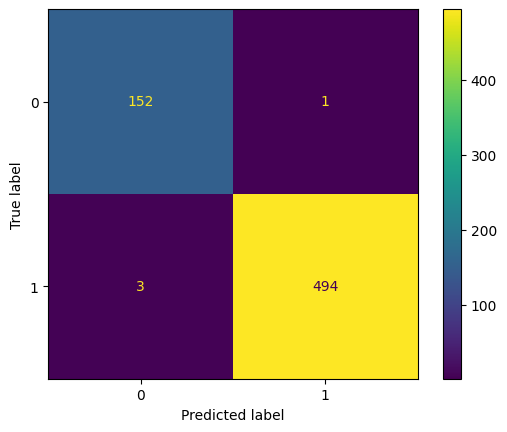

In [46]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, y_pred)

In [47]:
with open("wine_model.pkl", "wb") as model:
    pickle.dump(pipeline, model)

In [48]:
X = [["0.12", "0.034", "99", "0.57"]]
def predict():
    model = log_reg

    # def prediction(X):
    #     pred = model.predict(X)
    #     return jsonify({f"prediction_{i}": pred[i].astype(np.int8) for i in range(len(X))})

    acidity = X[0][0]
    chlorides = X[0][1]
    so2 = X[0][2]
    sulphates = X[0][3]

    if acidity is None or chlorides is None or so2 is None or sulphates is None:
        return "Args empty, not enough data to predict"
    else:
        X_pred = [[float(acidity),float(chlorides),float(so2), float(sulphates)]]
        prediction = model.predict(X_pred)

    print(X_pred, type(X_pred))
    
    return dict({'predictions': prediction[0]})

In [49]:
X_train_s

,volatile acidity,chlorides,total sulfur dioxide,sulphates
0,0.12,0.034,99.0,0.57
1,0.55,0.076,40.0,0.59
2,0.17,0.093,136.0,0.49
3,0.26,0.045,166.0,0.46
4,0.21,0.038,183.0,0.48
...,...,...,...,...
5842,0.24,0.047,211.0,0.57
5843,0.22,0.058,125.0,0.45
5844,0.20,0.052,145.0,0.56
5845,0.41,0.032,74.0,0.35


In [50]:
predict()

[[0.12, 0.034, 99.0, 0.57]] <class 'list'>


c:\Users\dario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'predictions': np.int64(1)}